##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [1]:
import os
import torch
from torch import nn
import random
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40303
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
import os
os.chdir('../')

In [4]:
os.getcwd()

'h:\\project'

## **Helper Functions**

In [5]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [6]:
from src.dataset import *

In [7]:
train_df, valid_df, _, _ = load_data()

In [8]:
_, pso_index = get_split(train_df, size=0.05)
train_pso = train_df.loc[pso_index, :]
train_pso.reset_index(drop=True, inplace=True)
train_pso.label.value_counts()

FAKE    187
REAL    185
Name: label, dtype: int64

In [9]:
_, pso_index = get_split(valid_df, size=0.25)
valid_pso = valid_df.loc[pso_index, :]
valid_pso.reset_index(drop=True, inplace=True)
valid_pso.label.value_counts()

FAKE    216
REAL    120
Name: label, dtype: int64

In [10]:
train_pso.head()

,filename,label,path,origin,frames,inv_frame
0,xjzmkuxskq.mp4,REAL,h:\project\dfdc\dfdc_part_1_1\xjzmkuxskq,dfdc,1,0
1,id42_id48_0002.mp4,FAKE,h:\project\CelebDF-v2\faces\id42_id48_0002,CelebDF-v2,1,0
2,jkonwkrhqp.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\jkonwkrhqp,dfdc,3,1
3,Sally_Kirkland_2,REAL,./youtube_faces_dataset/faces\Sally_Kirkland_2,ytf,1,0
4,vejylrlysf.mp4,FAKE,h:\project\dfdc\dfdc_part_2_1\vejylrlysf,dfdc,1,0


## **Run PSO optimization loop**

In [11]:
from src.models.deepfake_detectors import Efficientnet
from src.train_val_funcs import train_epoch, run_inference
from pso import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


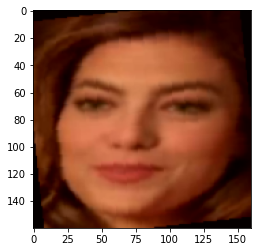

In [12]:
#preprocess the data
train_data = VideoDataset(train_pso, 50, transform = train_transforms(160))
val_data = VideoDataset(valid_pso, 50, transform = test_transforms(160))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
#plot the data
image,label = train_data[1]
im_plot(image[1,:,:,:])

In [13]:

def train_function(learning_rate=0.001, dropout_rate=0.3, image_size=112, frames_to_use=50, weight_decay=1e-5):
    #learning rate
    lr = learning_rate
    
    #preprocess the data
    train_data = VideoDataset(train_pso, frames_to_use, image_size, transform = train_transforms(image_size) )
    val_data = VideoDataset(valid_pso, frames_to_use, image_size, transform = test_transforms(image_size) )

    #load the data into dataloaders
    train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
    valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
    
    #instantiate the model
    model1 = Efficientnet(2, dropout_rate).cuda()
    #number of epochs 
    num_epochs = 5

    optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = weight_decay)

    criterion = nn.CrossEntropyLoss().cuda()
    train_loss_avg =[]
    train_accuracy = []
    val_loss_avg = []
    val_accuracy = []
    best_accuracy = 0
    for epoch in range(1,num_epochs+1):
        l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
        train_loss_avg.append(l)
        train_accuracy.append(acc)
        #validation step
        true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
        val_loss_avg.append(tl)
        val_accuracy.append(t_acc)
        if t_acc > best_accuracy:
            best_accuracy = t_acc
            torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    return tl
    

In [14]:
pso = PSO(w=0.75, hyperparam={'learning_rate':[1e-5, 1e-3], 'dropout_rate': [0.1, 0.9], 'image_size': [100, 128], 
                             'frames_to_use': [10,50] }, c1=1.5, c2=1.5, num_particles=8)

In [15]:
pso.run(train_function, generations=15)

generation  0 :

particle params:  [0.0004203068563018119, 0.35115935878742777, 109.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5273538661145029
personal best  [4.20306856e-04 3.51159359e-01 1.09000000e+02 4.10000000e+01]
global best  [4.20306856e-04 3.51159359e-01 1.09000000e+02 4.10000000e+01]
best score  0.5273538661145029
particle params:  [0.00027549686243654754, 0.45044917153488606, 110.0, 28.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5144923609637079
personal best  [2.75496862e-04 4.50449172e-01 1.10000000e+02 2.80000000e+01]
global best  [2.75496862e-04 4.50449172e-01 1.10000000e+02 2.80000000e+01]
best score  0.5144923609637079
particle params:  [0.00012904472154335272, 0.7784898068150077, 107.0, 25.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5318885523648489
personal best  [1.29044722e-04 7.78489807e-01 1.07000000e+02 2.50000000e+01]
global best  [2.75496862e-04 4.50449172e-01 1.10000000e+02 2.80000000e+01]
best score  0.5144923609637079
particle params:  [0.0003401375155193863, 0.46324162999631135, 102.0, 42.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.48419173274721417
personal best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
global best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
best score  0.48419173274721417
particle params:  [0.0007498418011741609, 0.6744502737667731, 100.0, 20.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6457323183616003
personal best  [7.49841801e-04 6.74450274e-01 1.00000000e+02 2.00000000e+01]
global best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
best score  0.48419173274721417
particle params:  [0.0005871297203229096, 0.8550670831603487, 106.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5464185313099906
personal best  [5.87129720e-04 8.55067083e-01 1.06000000e+02 1.00000000e+01]
global best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
best score  0.48419173274721417
particle params:  [0.0007057361171318672, 0.14705314818492665, 106.0, 35.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5659585013276055
personal best  [7.05736117e-04 1.47053148e-01 1.06000000e+02 3.50000000e+01]
global best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
best score  0.48419173274721417
particle params:  [0.0002449082452153001, 0.6014898286762126, 116.0, 32.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4691137625348
personal best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
generation  1 :

particle params:  [0.0006159293195718361, 0.3607483284233511, 109.0, 30.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5235732765424819
personal best  [6.15929320e-04 3.60748328e-01 1.09000000e+02 3.00000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.00028773769468194206, 0.6218827697448231, 107.0, 11.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.54069030746108
personal best  [2.75496862e-04 4.50449172e-01 1.10000000e+02 2.80000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [1e-05, 0.23125086171424325, 119.0, 33.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5905579495288077
personal best  [1.29044722e-04 7.78489807e-01 1.07000000e+02 2.50000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.0002686876598739932, 0.10888958626883949, 100.0, 21.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5094372864280429
personal best  [3.40137516e-04 4.63241630e-01 1.02000000e+02 4.20000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.0003382116365688292, 0.2672520418493287, 110.0, 27.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.548258819040798
personal best  [3.38211637e-04 2.67252042e-01 1.10000000e+02 2.70000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.0006513722634917836, 0.1936725059152734, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5698137474911553
personal best  [5.87129720e-04 8.55067083e-01 1.06000000e+02 1.00000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.0006194316811342972, 0.1, 101.0, 26.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6208760355200086
personal best  [7.05736117e-04 1.47053148e-01 1.06000000e+02 3.50000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [9.598439788711561e-05, 0.1969041748527589, 109.0, 25.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5209265322912306
personal best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
generation  2 :

particle params:  [0.0004161444321213086, 0.6039154350712002, 111.0, 25.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49709345932517734
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.00023367106822149295, 0.698611623889893, 118.0, 27.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5049134939908981
personal best  [2.33671068e-04 6.98611624e-01 1.18000000e+02 2.70000000e+01]
global best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
best score  0.4691137625348
particle params:  [0.000309068668453389, 0.8061895324083312, 124.0, 37.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4632577193634851
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003093516177689132, 0.848852952929298, 105.0, 44.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4769387404833521
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [1e-05, 0.2440315492795998, 123.0, 34.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6231912271607489
personal best  [3.38211637e-04 2.67252042e-01 1.10000000e+02 2.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003075600633175179, 0.7604852155043835, 112.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5111755813871112
personal best  [3.07560063e-04 7.60485216e-01 1.12000000e+02 1.00000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.000517115700732422, 0.22665261740658937, 104.0, 29.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5011777508826483
personal best  [5.17115701e-04 2.26652617e-01 1.04000000e+02 2.90000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00033898582401954035, 0.6794024687616461, 116.0, 27.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5372109704074406
personal best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
generation  3 :

particle params:  [2.664745200136394e-05, 0.786011223547316, 115.0, 28.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5097622236325627
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0002012428142646255, 0.6590176849226657, 123.0, 46.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4890337511897087
personal best  [2.01242814e-04 6.59017685e-01 1.23000000e+02 4.60000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0005333701697934308, 0.1, 128.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4757241344168073
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003395100124426146, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49853629086698803
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [1e-05, 0.8567624622121447, 121.0, 32.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6760727770271755
personal best  [3.38211637e-04 2.67252042e-01 1.10000000e+02 2.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [5.031624783424386e-05, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5057461747810954
personal best  [5.03162478e-05 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00036082743918632433, 0.8915848864301767, 126.0, 33.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49008826946928385
personal best  [3.60827439e-04 8.91584886e-01 1.26000000e+02 3.30000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00048320807707943555, 0.1, 100.0, 45.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49665600593600956
personal best  [2.44908245e-04 6.01489829e-01 1.16000000e+02 3.20000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
generation  4 :

particle params:  [0.00020811979708072794, 0.7968443936641798, 123.0, 33.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5248836066041674
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00032974254657592634, 0.7335969681115645, 127.0, 49.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5392757789010093
personal best  [2.01242814e-04 6.59017685e-01 1.23000000e+02 4.60000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00048509877578036583, 0.1, 122.0, 38.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.46350677666209994
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.000325240168655711, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5767397586078871
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00032245871601996236, 0.7879110373801759, 112.0, 34.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5260157028124446
personal best  [3.22458716e-04 7.87911037e-01 1.12000000e+02 3.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00023468918212091996, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.48098379586424145
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0001802882459067615, 0.1, 100.0, 37.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5295834030423846
personal best  [3.60827439e-04 8.91584886e-01 1.26000000e+02 3.30000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0001880652043539203, 0.1, 100.0, 47.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4673076481336639
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
generation  5 :

particle params:  [0.0005901975729544475, 0.7792480476436716, 100.0, 36.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5521753025906426
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003377102036154433, 0.8670012381472688, 122.0, 45.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5133763179183006
personal best  [2.01242814e-04 6.59017685e-01 1.23000000e+02 4.60000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00033832371591870986, 0.1, 120.0, 35.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.497810066810676
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00028806601860453405, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5334722545175326
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0005372397489050011, 0.762922729749979, 110.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49183779848473413
personal best  [5.37239749e-04 7.62922730e-01 1.10000000e+02 3.90000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003770071064148152, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5761031685840516
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00034601663901601555, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5045865649978319
personal best  [3.60827439e-04 8.91584886e-01 1.26000000e+02 3.30000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [8.509840789594989e-05, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5061683814440455
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
generation  6 :

particle params:  [0.00072390222305811, 0.6806229297671236, 100.0, 37.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5183793707262903
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00021528122116391864, 0.736916613336301, 120.0, 35.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4976652949338868
personal best  [2.01242814e-04 6.59017685e-01 1.23000000e+02 4.60000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0001966195175374125, 0.1, 127.0, 37.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5222274001155581
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00027107849957025795, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5000967174058869
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00038595514817322196, 0.7872944626077752, 118.0, 42.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5633477015154702
personal best  [5.37239749e-04 7.62922730e-01 1.10000000e+02 3.90000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00029444726715237453, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5073724396172024
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00041880026899030387, 0.1, 100.0, 36.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4729985225768316
personal best  [4.18800269e-04 1.00000000e-01 1.00000000e+02 3.60000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [5.1248411656946135e-05, 0.1, 100.0, 31.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5181778314567748
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
generation  7 :

particle params:  [0.0004431243332751923, 0.6856885984502337, 100.0, 27.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5510786033812023
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00022467039618749427, 0.6717813030574155, 125.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4762905243606794
personal best  [2.24670396e-04 6.71781303e-01 1.25000000e+02 4.10000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0002963159126271145, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.539528838580563
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.0003416444770741693, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5570287080038161
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
best score  0.4632577193634851
particle params:  [0.00035507048069810033, 0.7908732765714217, 125.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.45166136892068953
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00018329260711241077, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5283932011751902
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003352585128635904, 0.1, 100.0, 35.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6150847084465481
personal best  [4.18800269e-04 1.00000000e-01 1.00000000e+02 3.60000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00016456527256287378, 0.1, 100.0, 31.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.47735515591644107
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  8 :

particle params:  [0.00014681482921912717, 0.7035783254886868, 100.0, 24.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5445433159669241
personal best  [4.16144432e-04 6.03915435e-01 1.11000000e+02 2.50000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00023736938602008896, 0.7856664013367298, 128.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5069228864851452
personal best  [2.24670396e-04 6.71781303e-01 1.25000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00039672437109097115, 0.1, 111.0, 35.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5608544629954156
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003448915212674766, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5006063697593552
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003319069800917591, 0.7935573870441566, 100.0, 38.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5023154822133836
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00026796299715746885, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4972571638368425
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002963037103310977, 0.1, 100.0, 42.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.48294357068481897
personal best  [4.18800269e-04 1.00000000e-01 1.00000000e+02 3.60000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003853143345343879, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5652048374925341
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  9 :

particle params:  [9.605642312254078e-05, 0.7777316812385026, 100.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4964596068575269
personal best  [9.60564231e-05 7.77731681e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003638435465823355, 0.8091325255555395, 127.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4692626077504385
personal best  [3.63843547e-04 8.09132526e-01 1.27000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00031771422379119855, 0.1, 100.0, 38.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.47677272203422727
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00030764469053671677, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.48969396700461704
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003542370609810303, 0.794518228473602, 124.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.48402568023829234
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003342658186400408, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5128772837065515
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004138142591928283, 0.1, 100.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.46850686449380147
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004565282914004012, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5731224098375866
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  10 :

particle params:  [0.0003039751635629919, 0.8515914371527252, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5526432359502429
personal best  [9.60564231e-05 7.77731681e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00045209051118689863, 0.822768410747166, 124.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49981569108508883
personal best  [3.63843547e-04 8.09132526e-01 1.27000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002784164406348513, 0.1, 100.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.519511185941242
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00030693884639225796, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5154754193056197
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003734228517708726, 0.7901770771327844, 100.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4572593615878196
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002596319553292401, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5361842850134486
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004732944942387849, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5569241444269816
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00036809630092162165, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.512630979574862
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  11 :

particle params:  [0.0002331742873416422, 0.7800640542377222, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4736209685603778
personal best  [2.33174287e-04 7.80064054e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004267411368758294, 0.7790775869569625, 123.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49908027833416346
personal best  [3.63843547e-04 8.09132526e-01 1.27000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00035415871206875317, 0.1, 100.0, 38.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5199119498332342
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003484318874474023, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5768523652638707
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.000356223209551921, 0.7878959183920908, 100.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5039394799442518
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002956961759425357, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5129554445544878
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004652261136249083, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5074880016701562
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [4.550010849518828e-05, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5158325671440079
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  12 :

particle params:  [0.0002165367867888646, 0.7346700237418369, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5645637927310807
personal best  [2.33174287e-04 7.80064054e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002933184266815541, 0.7762504946457968, 126.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.453071976346629
personal best  [2.93318427e-04 7.76250495e-01 1.26000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004080071533623716, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4992324333815348
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00033451198833347106, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5425535685249737
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003410500453244044, 0.7932372470770105, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4682174285962468
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00034831911790614154, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6888810229443368
personal best  [2.34689182e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00038073678392745285, 0.1, 100.0, 42.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5568704640581494
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002540659324927598, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5674651027435348
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  13 :

particle params:  [0.000327432245074415, 0.792803256168764, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5341340743360066
personal best  [2.33174287e-04 7.80064054e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00021841978979599396, 0.7786092158223484, 128.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.47520713401692255
personal best  [2.93318427e-04 7.76250495e-01 1.26000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003715729418801766, 0.1, 100.0, 39.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5032049069801966
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003120366300149172, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5472506604024342
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00035624181198516794, 0.7914777327620929, 100.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.496368618948119
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00032886551322998967, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4679982293219793
personal best  [3.28865513e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003037992674139321, 0.1, 100.0, 42.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5023604375975472
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0004209339479323993, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.6170408190006301
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
generation  14 :

particle params:  [0.000315783800211591, 0.82570011685055, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5080691973368326
personal best  [2.33174287e-04 7.80064054e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00032071795579166997, 0.7903341706139992, 123.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5021181720353308
personal best  [2.93318427e-04 7.76250495e-01 1.26000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002329449114621912, 0.1, 100.0, 38.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.4901052486328852
personal best  [3.09068668e-04 8.06189532e-01 1.24000000e+02 3.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002990803934660878, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5027052870108968
personal best  [3.09351618e-04 8.48852953e-01 1.05000000e+02 4.40000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00036601135154629583, 0.7899328678925178, 100.0, 41.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.49969385209537687
personal best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0003261869629872874, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5470659917309171
personal best  [3.28865513e-04 1.00000000e-01 1.00000000e+02 1.00000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.00029859990047728354, 0.1, 100.0, 40.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.501654265891938
personal best  [4.13814259e-04 1.00000000e-01 1.00000000e+02 4.10000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953
particle params:  [0.0002139978565827114, 0.1, 100.0, 10.0]


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

fitness val  0.5033172152581669
personal best  [1.88065204e-04 1.00000000e-01 1.00000000e+02 4.70000000e+01]
global best  [3.55070481e-04 7.90873277e-01 1.25000000e+02 4.00000000e+01]
best score  0.45166136892068953


In [16]:
pso.gbest

[array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]),
 array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01

In [17]:
gbest = pd.DataFrame(pso.gbest, columns=['lr', 'dropout', 'im_size', 'num_frames'])
pbest = [pd.DataFrame(p.pbest, columns=['lr', 'dropout', 'im_size', 'num_frames']) for p in pso.particles]
pos = [pd.DataFrame(p.pos, columns=['lr', 'dropout', 'im_size', 'num_frames']) for p in pso.particles]




In [1]:
p = [pd.concat([pbest[i], pos[i]], axis=1) for i in range(len(pbest))]

NameError: name 'pbest' is not defined

In [19]:
import seaborn as sns
plt.figure()
sns.lineplot(data=gbest.loc[:,0])
for i,p in enumerate(pbest):
    p.position = pos[i].loc[:,0]
#    sns.lineplot(data=p.loc[:,0], hue='position' )

KeyError: 0

<Figure size 432x288 with 0 Axes>

In [ ]:
pbest[0].pos = pos[0].loc[:,0].to_list()

In [ ]:
pos[0].loc[:,0].to_list()

[0.0004203068563018119,
 0.0005507218318151613,
 0.0004898184566098946,
 0.0004114276029832419,
 0.0002360178883625092,
 0.00014838161284474045,
 0.00011187860360666057,
 0.00012565756759230708,
 0.00019374155149520921,
 0.00025348027495232376,
 0.0002083493879886098,
 0.00021210446681879484,
 0.0001752530859749189,
 0.00016888815772101747,
 0.00013647377894215196,
 0.00012623907654747834,
 0.00013551476190384862,
 0.00011752480329727869,
 0.00015942010106676744,
 0.0002910311041246405,
 0.00032713956120736926]

with open('Python.txt', 'rb') as f:
    dict = pickle.load(f)

In [ ]:
import pickle


In [ ]:
g1 = pickle.load(open("pso_pureeffnet.pickle","rb"))

In [ ]:
g1

,lr,dropout,im_size,num_frames
0,0.000340,0.463242,102.0,42.0
1,0.000237,0.212174,100.0,33.0
2,0.000237,0.212174,100.0,33.0
3,0.000236,0.209092,100.0,33.0
4,0.000215,0.225545,102.0,39.0
5,0.000215,0.225545,102.0,39.0
6,0.000215,0.225545,102.0,39.0
7,0.000321,0.197684,107.0,37.0
8,0.000321,0.197684,107.0,37.0
9,0.000273,0.368419,104.0,33.0


In [1]:
from numpy import array

gbest = [array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]),
 array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.09068668e-04, 8.06189532e-01, 1.24000000e+02, 3.70000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01]),
 array([3.55070481e-04, 7.90873277e-01, 1.25000000e+02, 4.00000000e+01])]

In [3]:
import pandas as pd 
gbest = pd.DataFrame(gbest, columns=['lr', 'dropout', 'im_size', 'num_frames'])

<AxesSubplot:ylabel='lr'>

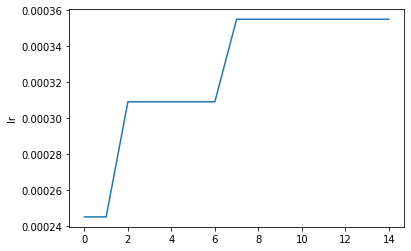

In [5]:
import seaborn as sns
sns.lineplot(data=gbest.loc[:,'lr'])

<AxesSubplot:ylabel='dropout'>

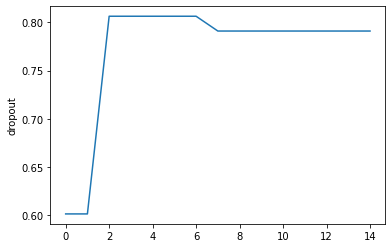

In [6]:
sns.lineplot(data=gbest.loc[:,'dropout'])

<AxesSubplot:ylabel='im_size'>

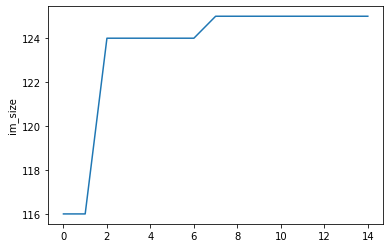

In [7]:
sns.lineplot(data=gbest.loc[:,'im_size'])

<AxesSubplot:ylabel='num_frames'>

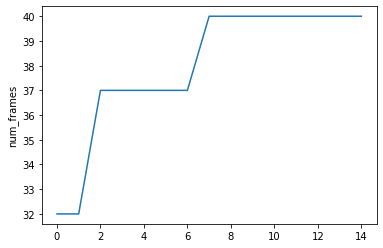

In [8]:
sns.lineplot(data=gbest.loc[:,'num_frames'])